# 02.10.30 - SVM MFCC20 T-SNE Dimensionality Reduction

## Prerequisites

- The dataset exists (if not, execute 00 - Dataset Initialisation)
- The dataset features have been populated (if not, execute 02 - Features Computation)


In [1]:
import warnings                      # This block prevents display of harmless warnings, but should be
warnings.filterwarnings('ignore')    # commented out till the experiment final version,
                                     # in order to avoid missing "real" warnings 

import kilroy_was_here               # Mandatory. Allow access to shared python code from repository root
from audace.jupytools import (
    iprint,                          # timestamped (to the ms) print with CPU and RAM consumption information  
    predestination,                  # Seeds various PRNGs for reproducibility
    say_my_name                      # gets notebook name
)

from audace.audiodataset import AudioDataset      # Main class for audio dataset handling

from IPython.display import display

# Experiment name will be used to prefix potential outputs
EXP_NAME = say_my_name()

# Dataset name is the master key for dataset adressing
# Change it according to the dataset you want to process
DATASET_NAME = 'MAIN1000'

# Initialize Dataset Object. 
ds = AudioDataset(DATASET_NAME)
    
# Display AudioDataset summary    
ds.info()

# Display cardinalities by hive attribute and queen label for samples with no external perturbation
sql = """
    select distinct hive, queen, count(*)
    from samples
    where nobee = 0
    group by hive, queen
    order by hive
    """
display(ds.queryDataFrame(sql))

[2020-09-08/16:32:43.091|14.2%|72.1%|0.28GB] ------------------------------------------------------
[2020-09-08/16:32:43.091|00.0%|72.1%|0.28GB] DATASET NAME          : MAIN1000
[2020-09-08/16:32:43.091|00.0%|72.1%|0.28GB] DATASET PATH          : D:\Jupyter\ShowBees\datasets\MAIN1000
[2020-09-08/16:32:43.091|00.0%|72.1%|0.28GB] DATASET DB PATH       : D:\Jupyter\ShowBees\datasets\MAIN1000\MAIN1000.db
[2020-09-08/16:32:43.092|00.0%|72.1%|0.28GB] DATASET SAMPLES PATH  : D:\Jupyter\ShowBees\datasets\MAIN1000\samples
[2020-09-08/16:32:43.092|00.0%|72.1%|0.28GB] NB SOURCE AUDIO FILES : 48
[2020-09-08/16:32:43.092|00.0%|72.1%|0.28GB] SAMPLE RATE           : 22050
[2020-09-08/16:32:43.092|00.0%|72.1%|0.28GB] DURATION              : 1.0
[2020-09-08/16:32:43.092|00.0%|72.1%|0.28GB] OVERLAP               : 0.0
[2020-09-08/16:32:43.092|00.0%|72.1%|0.28GB] NB AUDIO CHUNKS       : 24788
[2020-09-08/16:32:43.092|00.0%|72.1%|0.28GB] ------------------------------------------------------


,hive,queen,count(*)
0,CF001,0.0,14
1,CF003,1.0,3649
2,CJ001,0.0,790
3,GH001,1.0,1396
4,Hive1,0.0,1473
5,Hive1,1.0,2684
6,Hive3,0.0,6545
7,Hive3,1.0,654


In [4]:
import numpy as np
from sklearn import svm, metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from audace.jupytools import predestination
from audace.splitters import serie_to_2D

# Experiment parameters
FEATURE_NAME = 'mfcc20'
SET_FRAC = 1
TEST_FRAC = 0.9
KERNEL = 'rbf'
C = 1
GAMMA = 'scale'

# Seed the various PRNGs
predestination()

# Get pandas dataframe containing the columns we will need for this experiment,
# shuffle it (and potentially truncate it to speed quick tests)
iprint(">>>>> Query features and labels")
sql = F"select {FEATURE_NAME}, queen from samples where nobee = 0"
df = ds.queryDataFrame(sql).sample(frac=SET_FRAC)

# flatten features array
iprint(">>>>> Flatten features")
X = serie_to_2D(df[FEATURE_NAME])

iprint("Before dimensionality reduction:", X.shape)


# reduce dimensionality using t-sne
iprint(">>>>> t-SNE")
tsne = TSNE(n_components=2)
iprint("      fit transform X")
X = tsne.fit_transform(X)

iprint("After dimensionality reduction:", X.shape)


# get labels
y = df['queen']

# Partition dataset into training and test subsets
iprint(">>>>> Partition training/test")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_FRAC)

# It is usually a good idea to scale the data for SVM training. Classifiers usually
#perform better on normalized data
iprint(">>>>> Scale")
scaler = StandardScaler()
iprint("      fit transform train")
X_train = scaler.fit_transform(X_train)
iprint("      transform test")
X_test = scaler.transform(X_test)

#Create a svm Classifier, using the experiment parameters
iprint('>>>>> SVC')
clf = svm.SVC(kernel=KERNEL, C=C, gamma=GAMMA)

#Train the model using the training sets
iprint('      Train')
clf.fit(X_train, y_train)

#Predict the response for test dataset
iprint('      Predict')
y_pred = clf.predict(X_test)

# Display information about the classifier performance
iprint(F"Trained over {len(y_train)} / Tested over {len(y_test)}")
iprint("Accuracy  :",metrics.accuracy_score(y_test, y_pred))
iprint("Precision :",metrics.precision_score(y_test, y_pred))
iprint("Recall    :",metrics.recall_score(y_test, y_pred))
iprint("F-Measure :",metrics.f1_score(y_test, y_pred))


[2020-09-08/16:35:32.201|08.0%|72.5%|0.41GB] >>>>> Query features and labels
[2020-09-08/16:35:32.500|21.1%|73.6%|0.42GB] >>>>> Flatten features
[2020-09-08/16:35:32.572|17.5%|73.6%|0.42GB] Before dimensionality reduction: (17205, 880)
[2020-09-08/16:35:32.573|00.0%|73.6%|0.42GB] >>>>> t-SNE
[2020-09-08/16:35:32.573|00.0%|73.6%|0.42GB]       fit transform X
[2020-09-08/16:40:53.619|54.6%|72.2%|0.37GB] After dimensionality reduction: (17205, 2)
[2020-09-08/16:40:53.622|00.0%|72.2%|0.37GB] >>>>> Partition training/test
[2020-09-08/16:40:53.636|100.0%|72.3%|0.37GB] >>>>> Scale
[2020-09-08/16:40:53.638|00.0%|72.3%|0.37GB]       fit transform train
[2020-09-08/16:40:53.641|00.0%|72.3%|0.37GB]       transform test
[2020-09-08/16:40:53.644|00.0%|72.3%|0.37GB] >>>>> SVC
[2020-09-08/16:40:53.645|00.0%|72.3%|0.37GB]       Train
[2020-09-08/16:40:53.682|100.0%|72.3%|0.37GB]       Predict
[2020-09-08/16:40:53.776|27.1%|72.3%|0.37GB] Trained over 1720 / Tested over 15485
[2020-09-08/16:40:53.779|00

(1204, 2) (1204,)
(516, 2) (516,)


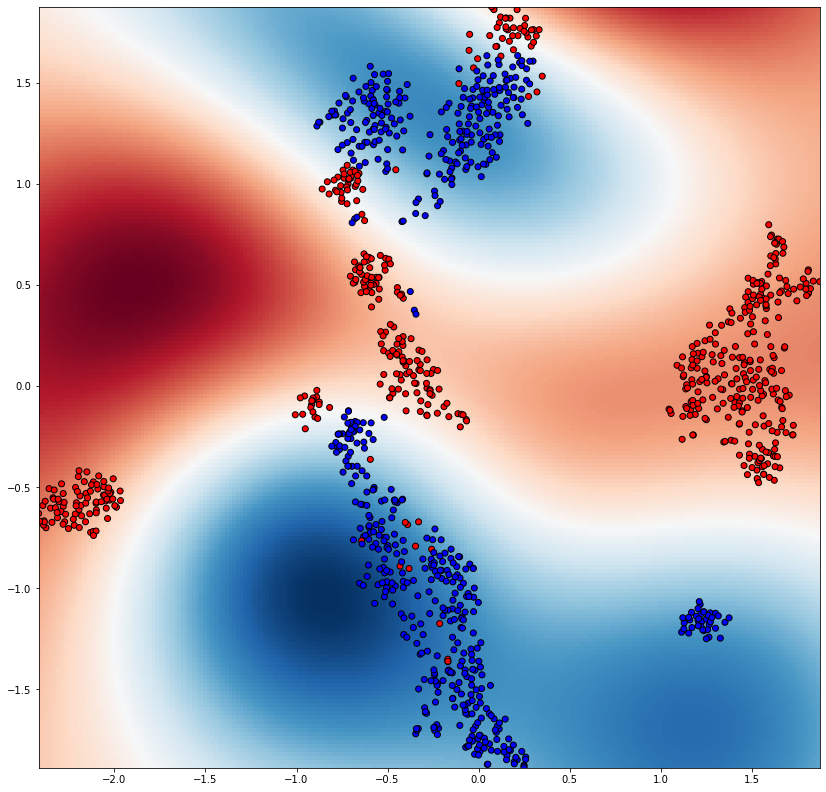

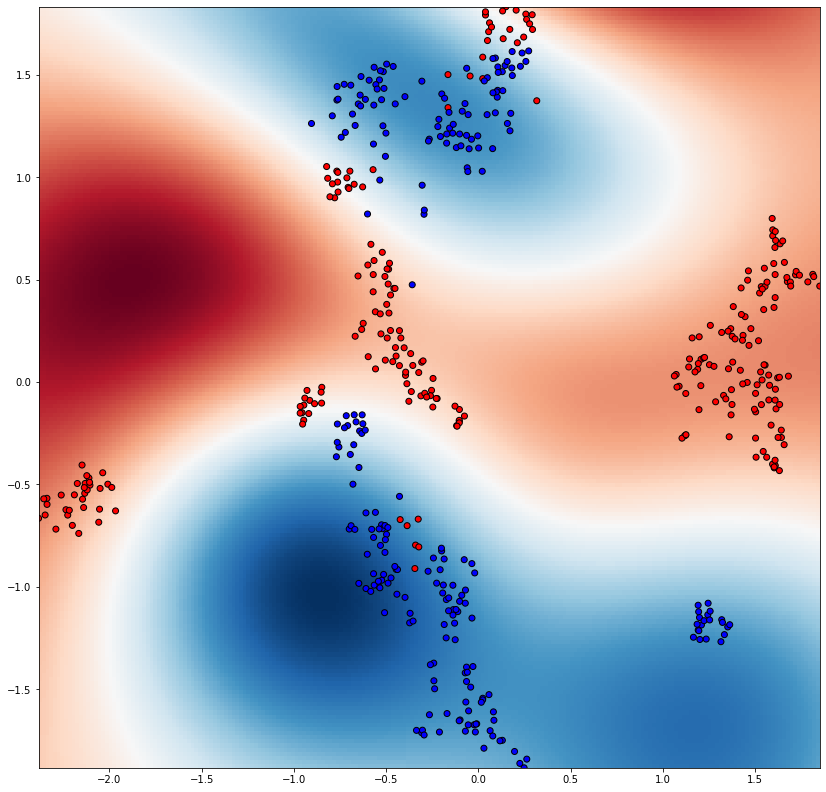

In [11]:
import numpy as np
import matplotlib.pyplot as plt

def plot_decision_function(clf, X, y):
    plt.figure(figsize=(14, 14))
    
    
    Xmin  = X[:, 0].min()
    Xmax  = X[:, 0].max()    
    Ymin  = X[:, 1].min()
    Ymax  = X[:, 1].max()   
    
    Xd = Xmax - Xmin
    Yd = Ymax -Ymin
    
   
    xx, yy = np.meshgrid(np.linspace(Xmin, Xmax, Xd*50), np.linspace(Ymin, Ymax, Yd*50))
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    plt.pcolormesh(xx, yy, -Z, cmap=plt.cm.RdBu)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.bwr, edgecolors='k')
    #plt.xticks(())
    #plt.yticks(())
    plt.axis('tight')


plot_decision_function(clf, X_train, y_train)
plot_decision_function(clf, X_test, y_test)    
    
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


#from audace.plotters import save_fig
#save_fig(EXP_NAME, 'MAIN0100 decision function')

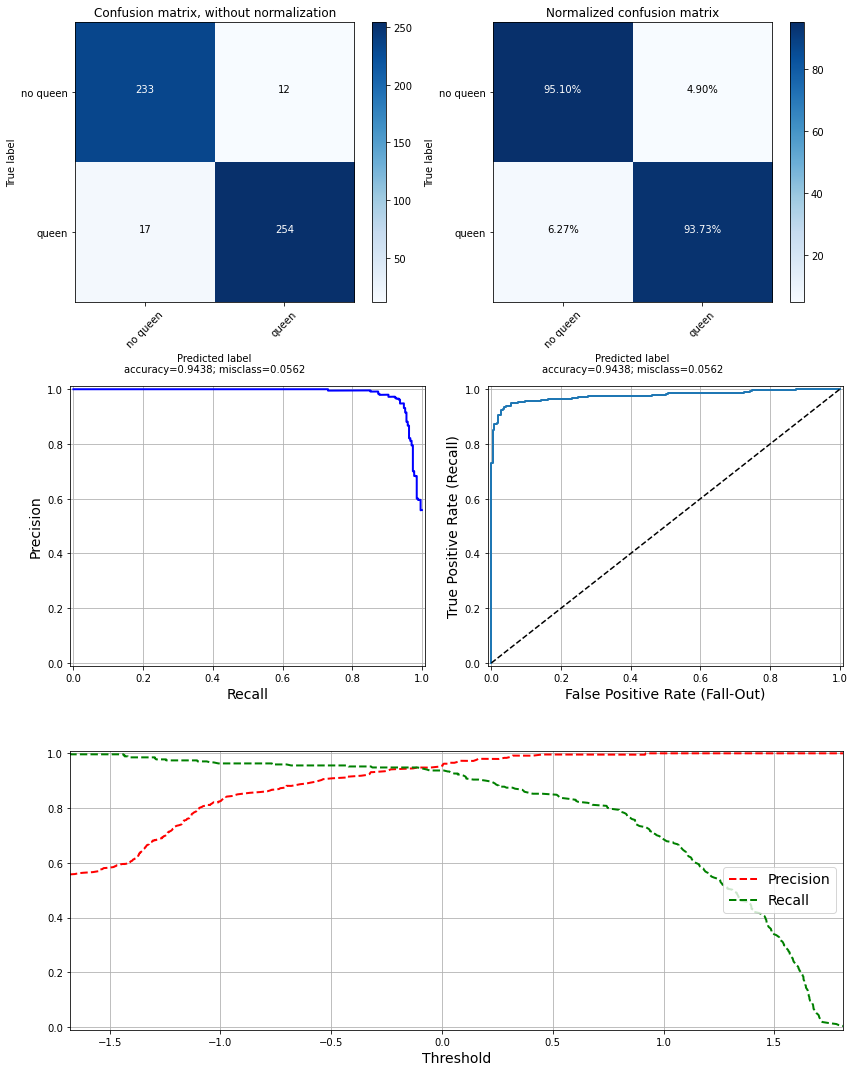

------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

    no queen       0.93      0.95      0.94       245
       queen       0.95      0.94      0.95       271

    accuracy                           0.94       516
   macro avg       0.94      0.94      0.94       516
weighted avg       0.94      0.94      0.94       516

------------------------------------------------------------------------------------------
Area Under ROC Curve 0.975630695082461
------------------------------------------------------------------------------------------


In [9]:
from audace.plotters import clf_full_report
from sklearn import metrics

target_names = ['no queen', 'queen']

tst = int(100*TEST_FRAC)
trn = 100 -tst

figure_name = F"Full Report {KERNEL} - ({DATASET_NAME}) - [Trn{trn:02d},Tst{tst:02d}] - C{C}"
if KERNEL != 'linear':
    figure_name += F" - G{GAMMA}"

clf_full_report(clf, X_test, y_test, target_names, EXP_NAME, figure_name)


print("------------------------------------------------------------------------------------------")
print(metrics.classification_report(y_test, y_pred , target_names=target_names))
print("------------------------------------------------------------------------------------------")
print('Area Under ROC Curve', metrics.roc_auc_score(y_test, clf.decision_function(X_test)))
print("------------------------------------------------------------------------------------------")

-------------------------------------
Accuracy: 0.19158504897061762
Precision: 0.30561555075593955
Recall: 0.03661534480527882
F1: 0.0653957250144425


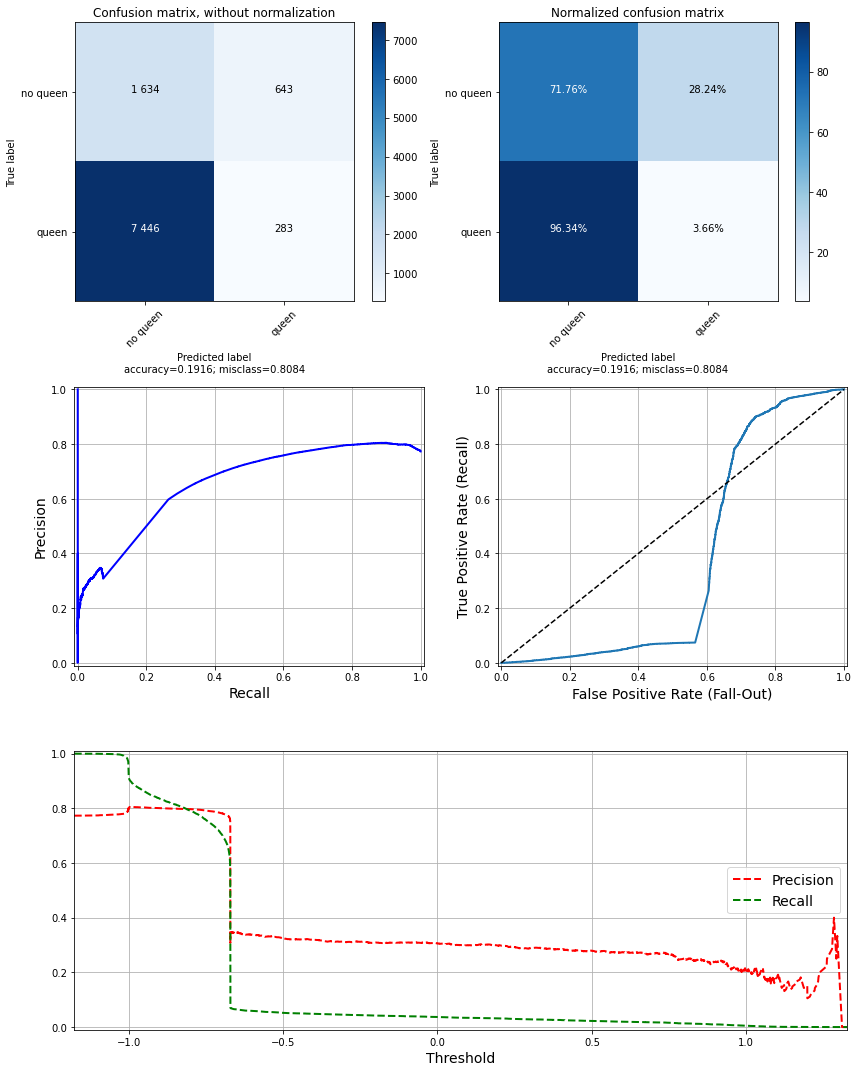

-------------------------------------
Accuracy: 0.2628142797610779
Precision: 0.02510716472749541
Recall: 0.18807339449541285
F1: 0.04430037817396003


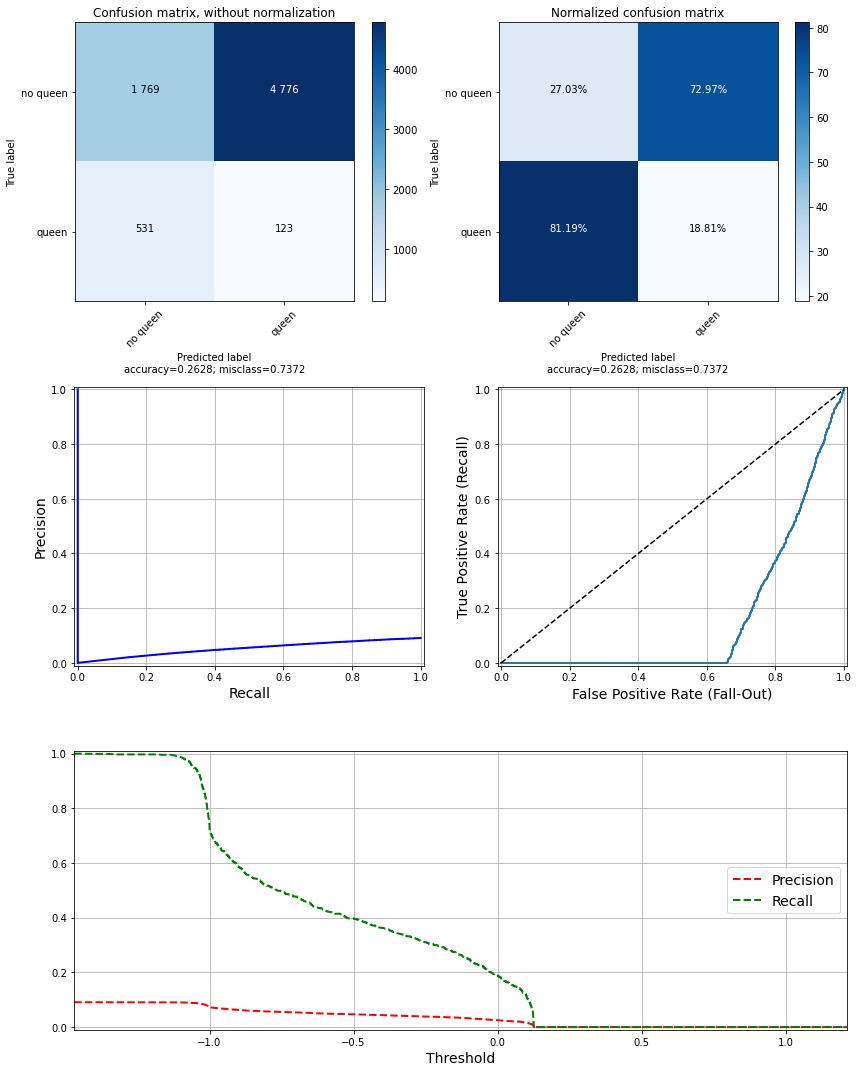

In [6]:
from sklearn import svm
from sklearn import metrics
from audace.plotters import clf_full_report
from sklearn.preprocessing import StandardScaler

FEATURE_NAME = 'mfcc20'
KERNEL = 'rbf'
C = 1
GAMMA = 100
TRAIN_FRAC = 1
target_names = ['no queen', 'queen']


df_fold1 = ds.queryDataFrame(F"select {FEATURE_NAME}, queen from samples where nobee = 0 and hive = 'Hive3'").sample(frac=1)
df_fold2 = ds.queryDataFrame(F"select {FEATURE_NAME}, queen from samples where nobee = 0 and hive != 'Hive3'").sample(frac=1)


def process_svm(X_train_serie, y_train, X_test_serie, y_test):
    X_train = feature_serie_to_flat_np(X_train_serie)
    X_test = feature_serie_to_flat_np(X_test_serie)

    #Create a svm Classifier
    clf = svm.SVC(kernel=KERNEL, C=C, gamma=GAMMA)

    # Scale
    scaler = StandardScaler()    
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)    

    
    # now reduce dimensionality using PCA
    pca = PCA(n_components = 2)
    X_train = pca.fit_transform(X_train)
    X_test = pca.transform(X_test)    
    
    
    # Rescale
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)      
    
    
    #Train the model using the training sets
    clf.fit(X_train, y_train)

    #Predict the response for test dataset
    y_pred = clf.predict(X_test)

    print("-------------------------------------")
    print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
    print("Precision:",metrics.precision_score(y_test, y_pred))
    print("Recall:",metrics.recall_score(y_test, y_pred))
    print("F1:",metrics.f1_score(y_test, y_pred))
    
    return clf, X_test, y_test


df_train = df_fold1.sample(frac = TRAIN_FRAC)
df_test = df_fold2

c, X, y = process_svm(df_train[FEATURE_NAME], df_train['queen'], df_test[FEATURE_NAME], df_test['queen'])
clf_full_report(c, X, y, target_names)
#plot_decision_function(clf, X, y)

df_train = df_fold2.sample(frac = TRAIN_FRAC)
df_test = df_fold1
c, X, y = process_svm(df_train[FEATURE_NAME], df_train['queen'], df_test[FEATURE_NAME], df_test['queen'])
clf_full_report(c, X, y, target_names)
#plot_decision_function(clf, X, y)


In [57]:
print(FEATURE_NAME)

for hive in ds.listAttributeValues('hive'):
    hive_df = ds.queryDataFrame(F"select {FEATURE_NAME}, queen from samples where nobee = 0 and hive = '{hive}'").sample(frac=1)
    hive_X = scaler.transform(feature_serie_to_flat_np(hive_df[FEATURE_NAME]))
    hive_y = hive_df['queen']
    hive_y_pred = clf.predict(hive_X)
    print(hive, metrics.accuracy_score(hive_y, hive_y_pred))
    



mfcc20
Hive1 0.96
Hive3 0.7183098591549296
